In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import shap
import xgboost as xgb
from optuna.integration import OptunaSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.inspection import permutation_importance
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix,
                             f1_score, precision_score, recall_score)
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier

In [3]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Датасет

In [4]:
df = pd.read_csv("../data/Skyserver_SQL2_27_2018 6_51_39 PM.csv")

Удаляем неинформативные колонки

In [5]:
df.drop(
    columns=[
        "objid",
        "run",
        "rerun",
        "camcol",
        "field",
        "specobjid",
        "fiberid",
        "plate",
        "mjd",
    ],
    inplace=True,
)

In [6]:
df.head()

,ra,dec,u,g,r,i,z,class,redshift
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,STAR,-0.000009
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,STAR,-0.000055
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,GALAXY,0.123111
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,STAR,-0.000111
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,STAR,0.000590


## Обучение

У нас задача - предсказать класс, поэтому разобьем датасет на фичи и целевую метку

In [7]:
X = df.drop(columns=["class"])
y = df["class"]

Разобьем данные на train и test подвыборки

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_SEED
)

Перед обучением надо предварительно конвертировать целевую метку в формат, удобный для модели. Выберем LabelEncoder, потому что у нас только одна категориальная переменная, и тут на самом деле без особой разницы, как именно ее кодировать. Если бы у нас было их несколько, то можно было бы использовать OneHotEncoder, чтобы модель не подумала, что между данными после препроцессинга LabelEncoder есть какая-то связь

In [9]:
enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)

## Подбор гиперпараметров

Будем подбирать следующие параметры:

- learning_rate: Этот параметр определяет размер шага градиентного спуска.

- n_estimators: Количество деревьев в ансамбле. Большее количество деревьев может улучшить производительность модели, но может также привести к переобучению.

- max_depth: Максимальная глубина каждого дерева. Это контролирует сложность каждого дерева. Большая глубина может привести к переобучению, поэтому обычно она подбирается на кросс-валидации.

- min_child_weight: Минимальная сумма весов (градиентов), необходимая для создания нового узла в дереве. Это может использоваться для контроля переобучения.

- subsample: Доля случайно выбранных образцов, используемых для обучения каждого дерева. Это может помочь в борьбе с переобучением.

- colsample_bytree: Доля случайно выбранных признаков для обучения каждого дерева. Также может помочь в управлении переобучением.

- gamma: Минимальное уменьшение значения функции потерь, необходимое для создания дополнительного узла дерева. Это также может помочь в управлении переобучением.

- scale_pos_weight: Используется для балансировки классов при несбалансированных наборах данных.

In [11]:
param_grid = {
    "learning_rate": [0.01, 0.1],
    "n_estimators": [50, 100, 150],
    "max_depth": [3, 4, 5],
    "min_child_weight": [1, 2, 3],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "gamma": [0, 0.1],
}
# Инициализация XGBoost-классификатора
xgb = XGBClassifier(
    objective="multi:softmax", num_class=len(set(y)), use_label_encoder=False, random_state=RANDOM_SEED
)

# Создание объекта GridSearchCV
grid_search = HalvingGridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="f1_weighted",
    cv=3,
    verbose=True,
    random_state=RANDOM_SEED,
)

# Выполнение подбора параметров
grid_search.fit(X_train, y_train)

# Извлечение результатов
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Наилучшие параметры:", best_params)
print("Наилучший показатель качества:", best_score)

n_iterations: 6
n_required_iterations: 7
n_possible_iterations: 6
min_resources_: 18
max_resources_: 7000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 972
n_resources: 18
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
----------
iter: 1
n_candidates: 324
n_resources: 54
Fitting 3 folds for each of 324 candidates, totalling 972 fits
----------
iter: 2
n_candidates: 108
n_resources: 162
Fitting 3 folds for each of 108 candidates, totalling 324 fits
----------
iter: 3
n_candidates: 36
n_resources: 486
Fitting 3 folds for each of 36 candidates, totalling 108 fits
----------
iter: 4
n_candidates: 12
n_resources: 1458
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 5
n_candidates: 4
n_resources: 4374
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Наилучшие параметры: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 50, 'subsample': 1.0}
Наи

Для того, чтобы подобрать параметры с помощью optuna, будем использовать ее интеграцию с sklearn

In [12]:
param = {
    "learning_rate": optuna.distributions.FloatDistribution(0.01, 0.1, log=True),
    "n_estimators": optuna.distributions.IntDistribution(50, 150),
    "max_depth": optuna.distributions.IntDistribution(3, 5),
    "min_child_weight": optuna.distributions.IntDistribution(1, 3),
    "subsample": optuna.distributions.FloatDistribution(0.8, 1.0),
    "colsample_bytree": optuna.distributions.FloatDistribution(0.8, 1.0),
    "gamma": optuna.distributions.FloatDistribution(0, 0.1),
}

# Создание объекта OptunaSearchCV
optuna_search = OptunaSearchCV(
    XGBClassifier(
        objective="multi:softmax", num_class=len(set(y)), use_label_encoder=False, random_state=RANDOM_SEED
    ),
    param,
    scoring="f1_weighted",
    n_trials=100,
    cv=3,
    verbose=1,
    random_state=RANDOM_SEED,
)

# Запуск поиска
optuna_search.fit(X_train, y_train)

print("Наилучшие параметры:", optuna_search.best_params_)
print("Наилучший показатель качества (F1-мера):", optuna_search.best_score_)

[I 2023-12-28 12:20:09,285] A new study created in memory with name: no-name-3ca6dd26-aa4b-4021-b06f-20a0a8036e10
[I 2023-12-28 12:20:09,286] Searching the best hyperparameters using 7000 samples...
[I 2023-12-28 12:20:09,784] Trial 0 finished with value: 0.9877609491779499 and parameters: {'learning_rate': 0.028490564366788033, 'n_estimators': 134, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8970374385951927, 'colsample_bytree': 0.8596523262730262, 'gamma': 0.02124262739922226}. Best is trial 0 with value: 0.9877609491779499.
[I 2023-12-28 12:20:10,012] Trial 1 finished with value: 0.9868840193737807 and parameters: {'learning_rate': 0.01468070250209044, 'n_estimators': 67, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.999850172068019, 'colsample_bytree': 0.9013369228447712, 'gamma': 0.023705948996927073}. Best is trial 0 with value: 0.9877609491779499.
[I 2023-12-28 12:20:10,453] Trial 2 finished with value: 0.9869349186773402 and parameters: {'learning_rate': 0.024

Наилучшие параметры: {'learning_rate': 0.05547519162793605, 'n_estimators': 133, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.8112069787047393, 'colsample_bytree': 0.822740346279938, 'gamma': 0.07071360967870914}
Наилучший показатель качества (F1-мера): 0.989653344378878


## Обучим модель

Обучим наулучшую модель. После подбора гиперпараметров разными способами мы выяснили, что наиболее хорошо их подобрала optuna.

In [13]:
xgb_model = XGBClassifier(
    objective="multi:softmax",
    num_class=len(set(y)),
    use_label_encoder=False,
    random_state=RANDOM_SEED,
    **optuna_search.best_params_,
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.822740346279938, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.07071360967870914,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05547519162793605,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=133, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

Посчитаем качество

In [14]:
def calculate_metrics(y_true, y_pred):
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
    print(f"F1: {f1_score(y_test, y_pred, average='weighted')}")

In [15]:
y_pred = xgb_model.predict(X_test)
calculate_metrics(y_test, y_pred)

Precision: 0.9916362216753603
Recall: 0.9916666666666667
F1: 0.991630676003265


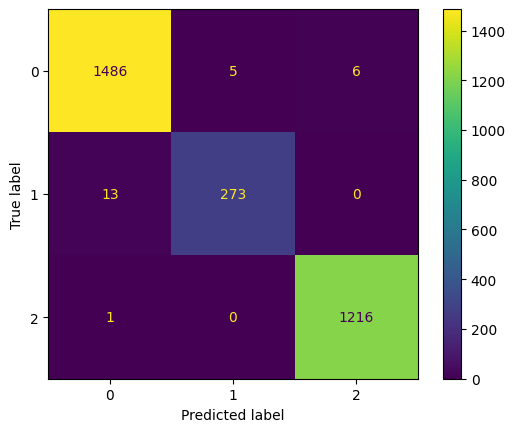

In [16]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Интерпретация модели

Построим Decision plot. Он покажет, как модель принимает решение

In [18]:
explainer = shap.TreeExplainer(xgb_model)

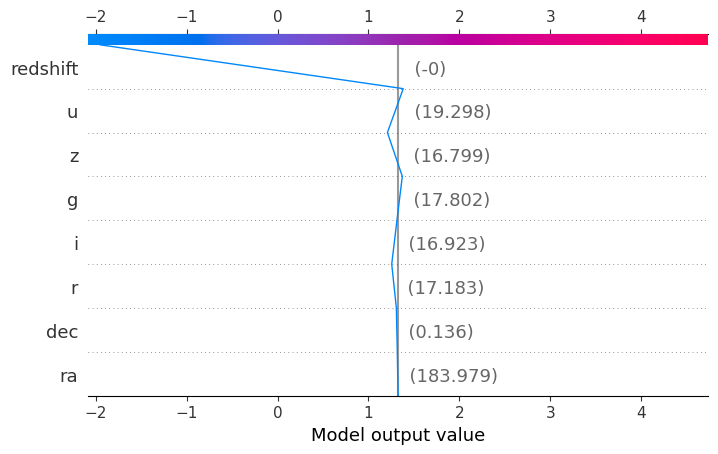

In [19]:
choosen_instance = X_test.loc[[10]]
shap_values = explainer.shap_values(choosen_instance)
shap.plots.decision(explainer.expected_value[0], shap_values[0], choosen_instance)

Посмотрим график сводной информации о важности признаков

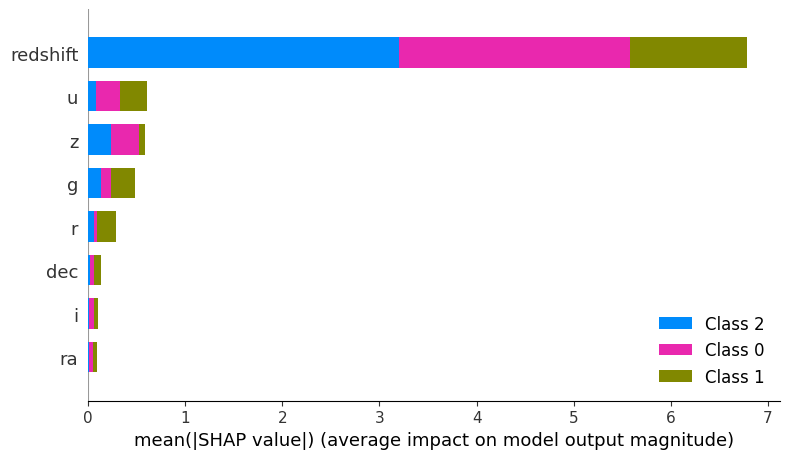

In [20]:
shap_values = explainer.shap_values(X_test.iloc[:100])
shap.summary_plot(shap_values, X_test.iloc[:100])

Построим график важности признаков

Text(0.5, 0, 'Xgboost Feature Importance')

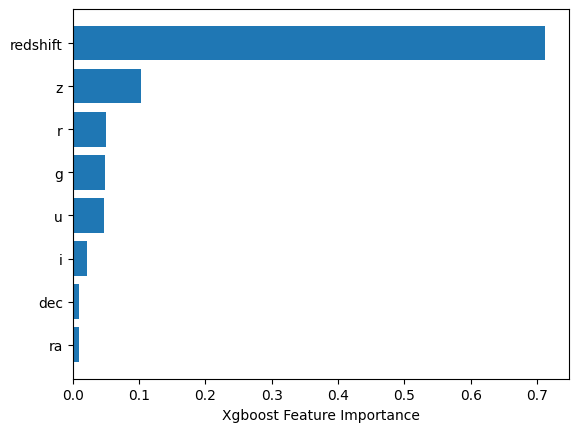

In [21]:
sorted_idx = xgb_model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

Построим график permutation importance

In [22]:
perm_importance = permutation_importance(xgb_model, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

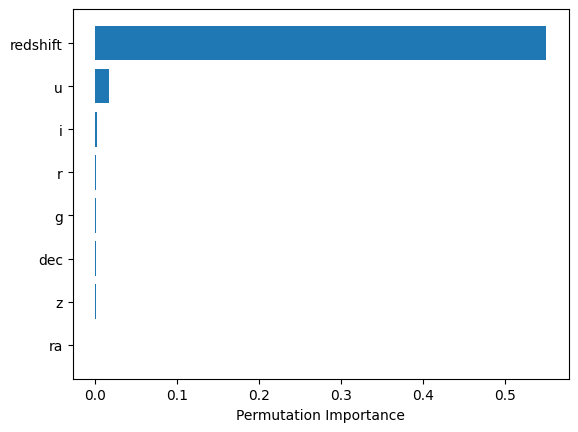

In [23]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

Вывод по интерпретации результатов работы модели: видим, что наибольший вклад вносит признак redshift. При EDA мы заметили, что, возможно, это расстояние от Земли до объекта в космосе, и так как для каждого класса это значение разное, мы можем отличать классы только на основе этого столбца, и это подтверждается